In [16]:
#!/usr/bin/env python3
import sys
import time
import numpy as np
import sqlite3
import requests
import json
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# --- Database and Global Setup ---

# Create sqlite db if it doesn't exist
try:
    with open('bcinfo.sqlite', "r") as dbfr:
        pass
except FileNotFoundError:
    with open('bcinfo.sqlite', "w") as dbfw:
        pass

# Global parameters
ymax = 5000000                   # gnuplot price range max
forced = False                   # option to run script forced
boxfact = 0.942                  # factor for text box position
textfact = 0.963                 # factor for text label position
extendto = int(datetime.now().timestamp()) + 153878400  # extend 5 years into the future

# Connect to database and ensure table exists
conn = sqlite3.connect('bcinfo.sqlite')
cur = conn.cursor()
cur.execute('SELECT count(name) FROM sqlite_master WHERE type="table" AND name="btc"')
if cur.fetchone()[0] == 0:
    cur.execute('''
        CREATE TABLE btc ( date int PRIMARY KEY, price float, coins float );
    ''')
    conn.commit()

# Read existing data (sorted by date)
cur.execute('SELECT * FROM btc ORDER BY date')
bstr = cur.fetchall()

# If no data is available, use a valid default start date (e.g., 2013-01-10)
if len(bstr) > 0:
    maxdt = bstr[-1][0]
else:
    valid_start = int(datetime.strptime("2013-01-10", "%Y-%m-%d").timestamp() / 86400)
    maxdt = valid_start

# --- Fetch Data from CoinMetrics API ---

if "--regen" not in sys.argv:
    forced = forced or "--force" in sys.argv
    today = int(datetime.now().timestamp() / 86400)
    loopval = maxdt - 2
    burl = 'https://community-api.coinmetrics.io/v4/timeseries/asset-metrics'
    bapistr = '?assets=btc&frequency=1d&metrics=PriceUSD%2CSplyCur&start_time='
    curstock = 0

    while loopval <= today:
        startdate = datetime.fromtimestamp(loopval * 86400).strftime('%F')
        enddate = datetime.fromtimestamp((loopval + 100) * 86400).strftime('%F')
        url = burl + bapistr + startdate + '&end_time=' + enddate
        print("Requesting:", url)
        
        # Handle rate limiting: if status 429, wait and retry up to 5 times.
        max_retries = 5
        retries = 0
        newdata = requests.get(url)
        while newdata.status_code == 429 and retries < max_retries:
            retry_after = newdata.headers.get("Retry-After")
            wait_time = int(retry_after) if retry_after is not None else 60
            print("Rate limit exceeded (429). Waiting for", wait_time, "seconds before retrying...")
            time.sleep(wait_time)
            newdata = requests.get(url)
            retries += 1
        
        if newdata.status_code != 200:
            print("Getting data from coinmetrics failed with status", newdata.status_code)
            sys.exit(1)
        
        jdata = newdata.json()
        for bd in jdata['data']:
            # Replace None with 0 for missing values
            if bd['PriceUSD'] is None:
                bd['PriceUSD'] = 0
            if bd['SplyCur'] is None:
                bd['SplyCur'] = 0
            # Only accept increasing supply values
            if float(bd['SplyCur']) < curstock:
                continue
            curstock = float(bd['SplyCur'])
            epdate = int(float(datetime.strptime(bd['time'], '%Y-%m-%dT%H:%M:%S.000000000Z')
                                  .strftime('%s')) / 86400 + 0.5)
            if epdate <= maxdt:
                continue
            newentry = (epdate, float(bd['PriceUSD']), float(bd['SplyCur']))
            cur.execute('INSERT OR REPLACE INTO btc VALUES (?,?,?)', newentry)
            bstr.append(newentry)
        loopval += 98

    if maxdt == bstr[-1][0] and not forced:
        sys.exit()
    conn.commit()
    maxdt = bstr[-1][0]

# --- Data Processing and Regression ---

# We will compute S2F (stock-to-flow) using:
# S2F = current coins / (current coins - coins from 365 days ago)
# Thus, we require at least 365 days of prior data.
dt = []       # timestamps (in seconds)
price = []    # Bitcoin prices
coins = []    # circulating coins (from the API)
height = []   # estimated block height (for later use)
sf = []       # stock-to-flow values
lnsf = []     # natural logarithm of S2F values (for regression)
lnprice = []  # natural logarithm of price values (for regression)

p = 0         # halving period counter
ncoins = 0    # coins issued at the beginning of current period

# Ensure we have enough data (i must be >= 365)
if len(bstr) < 366:
    print("Not enough data in the database to compute stock-to-flow.")
    sys.exit(1)

# Loop from 365 to len(bstr) so we can use data from exactly 365 days earlier
for i in range(365, len(bstr)):
    # Skip records with zero price
    if bstr[i][1] == 0:
        continue
    current_date = bstr[i][0]
    current_price = bstr[i][1]
    current_coins = bstr[i][2]
    prev_coins = bstr[i-365][2]  # coins from 365 days earlier

    diff = current_coins - prev_coins
    if diff <= 0:
        # Avoid division by zero or negative increments
        continue

    s2f = current_coins / diff

    # Append the available data
    dt.append(current_date * 86400)
    price.append(current_price)
    coins.append(current_coins)
    
    # Update halving logic if needed
    if current_coins >= ncoins + 210000 * 50 / (2**p):
        ncoins += 210000 * 50 / (2**p)
        p += 1
    h = 210000 * p + (current_coins - ncoins) * 2**p / 50
    height.append(h)
    
    # Only add records where S2F is positive
    if s2f <= 0:
        continue
    sf.append(s2f)
    try:
        lnsf.append([np.log(s2f)])
        lnprice.append([np.log(current_price)])
    except Exception as e:
        print(f"Error computing log for S2F {s2f} or price {current_price}: {e}")
        continue

# Check that we have valid data for regression
if len(lnsf) == 0 or len(lnprice) == 0:
    print("No valid stock-to-flow data available for regression.")
    sys.exit(1)

# --- Extend Data into the Future ---

# Save current length of sf to index regression data later
lstsf = len(sf)
while dt[-1] < extendto:
    dt.append(dt[-1] + 86400)
    height.append(height[-1] + 144)
    if int(height[-1] / 210000) > p:
        ncoins += 210000 * 50 / (2**p)
        p += 1
    new_coins = ncoins + (height[-1] % 210000) * 50 / (2**p)
    coins.append(new_coins)
    # For extended data, use the coin supply from 361 days ago
    diff_ext = new_coins - coins[-361]
    if diff_ext <= 0:
        sf_value = 0
    else:
        sf_value = new_coins / diff_ext
    sf.append(sf_value)
    # (Note: We do not add extended points to the regression lists.)

# --- Linear Regression on Log-Transformed Data ---

regression_model = LinearRegression()
regression_model.fit(lnsf, lnprice)
lnpr_pred = regression_model.predict(lnsf)

rmse = mean_squared_error(lnprice, lnpr_pred)
r2 = r2_score(lnprice, lnpr_pred)
slope = regression_model.coef_[0][0]
intercept = regression_model.intercept_[0]
e2rmse = np.exp(rmse)
e2intc = np.exp(intercept)

print("Regression results:")
print("Slope:", slope)
print("Intercept:", intercept)
print("RMSE:", rmse)
print("R²:", r2)

# --- Generate Output Files ---

# Calculate min and max Y values for detail chart
detymax = 0
detymin = 10**15
for i in range(maxdt - 731, maxdt):
    idx = lstsf + i - maxdt - 1
    # Ensure index and price boundaries
    if i - maxdt - 1 < 0 or i - maxdt - 1 >= len(price):
        continue
    candidate1 = sf[idx]**slope * e2intc * e2rmse * 2
    candidate2 = price[i - maxdt - 1]
    detymax = max(detymax, candidate1, candidate2)
    candidate3 = sf[idx]**slope * e2intc / e2rmse / 2
    candidate4 = price[i - maxdt - 1]
    detymin = min(detymin, candidate3, candidate4)

for i in range(maxdt, maxdt + 61):
    idx = lstsf + i - maxdt - 1
    if idx < 0 or idx >= len(sf):
        continue
    detymax = max(detymax, sf[idx]**slope * e2intc * e2rmse * 2)
    detymin = min(detymin, sf[idx]**slope * e2intc / e2rmse / 2)
detymax *= 1.5
detymin /= 1.5

yrange = np.log(detymax / detymin)
detybox = np.exp(boxfact * yrange) * detymin
detytxt = np.exp(textfact * yrange) * detymin

# Write gnuplot variable file
with open('gpvars.txt', 'w') as gpvars:
    gpvars.write(str(round(slope, 2)) + "\n")
    gpvars.write(str(round(e2intc, 2)) + "\n")
    gpvars.write(str(round(rmse, 4)) + "\n")
    gpvars.write(str(round(r2, 4)) + "\n")
    gpvars.write(str(round(e2rmse, 2)) + "\n")
    gpvars.write(str(int(maxdt * 86400)) + "\n")
    gpvars.write(str((0.01 / e2intc)**(1 / slope)) + "\n")
    gpvars.write(str((ymax / e2intc)**(1 / slope)) + "\n")
    gpvars.write(str(ymax) + "\n")
    gpvars.write(str(round(intercept, 2)) + "\n")
    gpvars.write(str(int((maxdt - 731) * 86400)) + "\n")
    gpvars.write(str(int((maxdt + 61) * 86400)) + "\n")
    gpvars.write(str(detymax) + "\n")
    gpvars.write(str(int((maxdt - 480) * 86400)) + "\n")
    gpvars.write(str(detymin) + "\n")
    gpvars.write(str(detybox) + "\n")
    gpvars.write(str(detytxt) + "\n")

# Write timeline chart data for gnuplot
with open('sftime.csv', 'w') as gpdata:
    for i in range(len(dt)):
        sfval = sf[i]**slope * e2intc
        sd1p = sfval * e2rmse
        sd2p = sd1p * 2
        sd1m = sfval / e2rmse
        sd2m = sd1m / 2
        price_val = price[i] if i < len(price) else ""
        gpdata.write(",".join(str(x) for x in [dt[i], sfval, sd1p, sd2p, sd1m, sd2m, price_val]) + "\n")

# Write regression line data for gnuplot
with open("sfdata.csv", "w") as sfdata:
    for i in range(len(lnsf)):
        sfdata.write(str(lnsf[i][0]) + "," + str(lnprice[i][0]) + "\n")

# Write shell script variables for table display
idx = len(lnprice) - 1
with open("bashvar.sh", "w") as bashvar:
    bashvar.write("SFDT=" + str(dt[idx]) + "\n")
    bashvar.write("SFCP=" + str(round(float(price[idx]), 2)) + "\n")
    bashvar.write("SFPP=" + str(round(float(sf[idx]**slope * e2intc), 2)) + "\n")
    bashvar.write("SFPP1=" + str(round(float(sf[idx]**slope * e2intc * e2rmse), 2)) + "\n")
    bashvar.write("SFPM1=" + str(round(float(sf[idx]**slope * e2intc / e2rmse), 2)) + "\n")
    bashvar.write("SFPP2=" + str(round(float(sf[idx]**slope * e2intc * e2rmse * 2), 2)) + "\n")
    bashvar.write("SFPM2=" + str(round(float(sf[idx]**slope * e2intc / e2rmse / 2), 2)) + "\n")

print("Data files created")




Requesting: https://community-api.coinmetrics.io/v4/timeseries/asset-metrics?assets=btc&frequency=1d&metrics=PriceUSD%2CSplyCur&start_time=2025-03-01&end_time=2025-06-09


SystemExit: 

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [18]:
len(bstr)

4435

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assume bstr is your cached data with len(bstr) == 4435

dt = []       # timestamps (seconds)
prices = []   # Bitcoin prices
coins = []    # circulating coin supply
sf = []       # stock-to-flow values
lnsf = []     # log(S2F) for regression
lnprice = []  # log(price) for regression

# We require at least 365 days of prior data for the S2F calculation.
# Loop from index 365 to the end of bstr.
for i in range(365, len(bstr)):
    current = bstr[i]
    prev = bstr[i-365]
    
    day, price_val, coins_val = current
    _, _, coins_prev = prev
    
    # Calculate the difference in coins over the past year.
    diff = coins_val - coins_prev
    if diff <= 0:
        continue  # Skip if no growth or invalid difference.
    
    s2f_val = coins_val / diff
    if s2f_val <= 0:
        continue  # Skip if S2F is nonpositive.
    
    # Save the values. Convert day to seconds.
    dt.append(day * 86400)
    prices.append(price_val)
    coins.append(coins_val)
    sf.append(s2f_val)
    
    try:
        lnsf.append([np.log(s2f_val)])
        lnprice.append([np.log(price_val)])
    except Exception as e:
        print(f"Error computing logarithms for S2F={s2f_val} or price={price_val}: {e}")
        
if len(lnsf) == 0 or len(lnprice) == 0:
    print("No valid S2F data available for regression.")
else:
    # Perform linear regression on the log-transformed data.
    regression_model = LinearRegression()
    regression_model.fit(lnsf, lnprice)
    lnpr_pred = regression_model.predict(lnsf)
    
    rmse = mean_squared_error(lnprice, lnpr_pred)
    r2 = r2_score(lnprice, lnpr_pred)
    slope = regression_model.coef_[0][0]
    intercept = regression_model.intercept_[0]
    
    print("Regression results:")
    print("Slope:", slope)
    print("Intercept:", intercept)
    print("RMSE:", rmse)
    print("R²:", r2)


Regression results:
Slope: 2.5078198578889226
Intercept: 0.3956163581295993
RMSE: 0.24806681149219878
R²: 0.9302305116788768


Loaded 4435 records from the database.


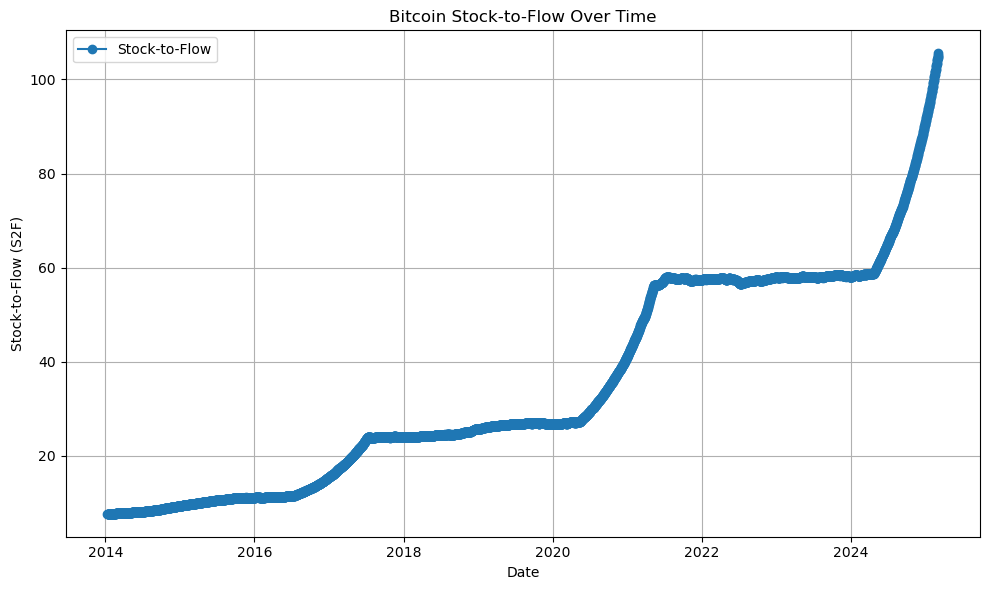

In [20]:
#!/usr/bin/env python3
import sys
import time
import sqlite3
import requests
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# === Helper Function: Fetch New Data from API ===
def fetch_new_data(maxdt):
    """
    Fetch new Bitcoin data from the CoinMetrics API starting from maxdt.
    Returns a list of new records, each a tuple: (date, price, coins).
    """
    today = int(datetime.now().timestamp() / 86400)
    loopval = maxdt - 2  # start a couple of days before last record
    burl = 'https://community-api.coinmetrics.io/v4/timeseries/asset-metrics'
    bapistr = '?assets=btc&frequency=1d&metrics=PriceUSD%2CSplyCur&start_time='
    curstock = 0
    new_entries = []
    while loopval <= today:
        startdate = datetime.fromtimestamp(loopval * 86400).strftime('%F')
        enddate = datetime.fromtimestamp((loopval + 100) * 86400).strftime('%F')
        url = burl + bapistr + startdate + '&end_time=' + enddate
        print("Requesting:", url)
        
        # Handle rate limiting (HTTP 429)
        max_retries = 5
        retries = 0
        r = requests.get(url)
        while r.status_code == 429 and retries < max_retries:
            retry_after = r.headers.get("Retry-After")
            wait_time = int(retry_after) if retry_after is not None else 60
            print("Rate limit hit. Waiting", wait_time, "seconds...")
            time.sleep(wait_time)
            r = requests.get(url)
            retries += 1
        if r.status_code != 200:
            print("Failed to fetch data: HTTP", r.status_code)
            break
        
        jdata = r.json()
        for bd in jdata.get('data', []):
            # Replace None values with 0
            if bd['PriceUSD'] is None:
                bd['PriceUSD'] = 0
            if bd['SplyCur'] is None:
                bd['SplyCur'] = 0
            # Only accept if supply is non-decreasing
            if float(bd['SplyCur']) < curstock:
                continue
            curstock = float(bd['SplyCur'])
            epdate = int(float(datetime.strptime(bd['time'], '%Y-%m-%dT%H:%M:%S.000000000Z')
                                  .strftime('%s')) / 86400 + 0.5)
            if epdate <= maxdt:
                continue
            new_entry = (epdate, float(bd['PriceUSD']), float(bd['SplyCur']))
            new_entries.append(new_entry)
        loopval += 98
    return new_entries

# === Database Setup: Load or Create SQLite DB ===
db_path = 'bcinfo.sqlite'
conn = sqlite3.connect(db_path)
cur = conn.cursor()
# Create table if it doesn't exist
cur.execute('SELECT count(name) FROM sqlite_master WHERE type="table" AND name="btc"')
if cur.fetchone()[0] == 0:
    cur.execute('CREATE TABLE btc (date INTEGER PRIMARY KEY, price REAL, coins REAL)')
    conn.commit()

# Load all data from the database (sorted by date)
cur.execute('SELECT * FROM btc ORDER BY date')
bstr = cur.fetchall()
print(f"Loaded {len(bstr)} records from the database.")

# Set maxdt from the most recent record, or use a default start date if empty.
if len(bstr) > 0:
    maxdt = bstr[-1][0]
else:
    maxdt = int(datetime.strptime("2013-01-10", "%Y-%m-%d").timestamp() / 86400)

# If "--regen" is provided, fetch new data from the API and append it.
if "--regen" in sys.argv:
    new_data = fetch_new_data(maxdt)
    print(f"Fetched {len(new_data)} new records.")
    for entry in new_data:
        cur.execute("INSERT OR REPLACE INTO btc VALUES (?, ?, ?)", entry)
        bstr.append(entry)
    conn.commit()
    bstr.sort(key=lambda x: x[0])  # ensure sorted by date
    maxdt = bstr[-1][0]
    print(f"Database updated, total records: {len(bstr)}")

# === Data Processing: Compute Stock-to-Flow (S2F) ===
# We need at least 365 days of prior data for S2F calculation.
if len(bstr) < 366:
    print("Not enough data to compute stock-to-flow.")
    conn.close()
    sys.exit(1)

dates_plot = []  # will store datetime objects for plotting
s2f_values = []  # computed stock-to-flow values

# For each record from index 365 onward, compute:
#   S2F = current_coins / (current_coins - coins from 365 days ago)
for i in range(365, len(bstr)):
    current = bstr[i]
    prev = bstr[i-365]
    current_date, current_price, current_coins = current
    _, _, prev_coins = prev
    diff = current_coins - prev_coins
    if diff <= 0:
        continue  # skip invalid values
    s2f = current_coins / diff
    if s2f <= 0:
        continue
    # Convert the stored day value to a proper datetime
    date_obj = datetime.fromtimestamp(current_date * 86400)
    dates_plot.append(date_obj)
    s2f_values.append(s2f)

if len(dates_plot) == 0:
    print("No valid stock-to-flow data available for plotting.")
    conn.close()
    sys.exit(1)

# === Plotting S2F ===
plt.figure(figsize=(10, 6))
plt.plot(dates_plot, s2f_values, marker='o', linestyle='-', label='Stock-to-Flow')
plt.xlabel("Date")
plt.ylabel("Stock-to-Flow (S2F)")
plt.title("Bitcoin Stock-to-Flow Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Optionally, you can save the plot with:
# plt.savefig("s2f_plot.png")

conn.close()


In [22]:
#!/usr/bin/env python3
import sys
import time
import sqlite3
import requests
import json
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------------------------------------------------
# 1. Database and Data Loading
# ----------------------------------------------------------------------

DB_PATH = "bcinfo.sqlite"

conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Ensure table exists
cur.execute('SELECT count(name) FROM sqlite_master WHERE type="table" AND name="btc"')
if cur.fetchone()[0] == 0:
    cur.execute('CREATE TABLE btc (date INTEGER PRIMARY KEY, price REAL, coins REAL)')
    conn.commit()

# Load all data
cur.execute('SELECT * FROM btc ORDER BY date')
bstr = cur.fetchall()
print(f"Loaded {len(bstr)} records from the database.")

# Determine the last date in our records (as day count)
if bstr:
    maxdt = bstr[-1][0]
else:
    # Default start date if DB is empty: 2013-01-10
    maxdt = int(datetime.strptime("2013-01-10", "%Y-%m-%d").timestamp() / 86400)

# ----------------------------------------------------------------------
# 2. Optional: Fetch New Data with "--regen"
# ----------------------------------------------------------------------

def fetch_new_data(start_day):
    """Fetch new BTC data from CoinMetrics starting from start_day."""
    today = int(datetime.now().timestamp() / 86400)
    loopval = start_day - 2
    new_entries = []
    burl = "https://community-api.coinmetrics.io/v4/timeseries/asset-metrics"
    bapistr = "?assets=btc&frequency=1d&metrics=PriceUSD%2CSplyCur&start_time="
    curstock = 0

    while loopval <= today:
        startdate = datetime.fromtimestamp(loopval * 86400).strftime('%F')
        end


Loaded 4435 records from the database.
